# An example with a split network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import sys

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

sys.path.append("../")


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Define a network.

In [3]:
import convex_adversarial

eye = torch.eye(2)
split1 = nn.Linear(2,1, bias=False)
split1.weight = nn.Parameter(eye[:1])
split1.weight.requires_grad = False
split2 = nn.Linear(2,1, bias=False)
split2.weight = nn.Parameter(eye[1:])
split2.weight.requires_grad = False

netSplit = convex_adversarial.DenseSequential(
    # add a no-op mapping for Dense support, since Dense operators don't currently work directly on input layers
    convex_adversarial.Dense(nn.Sequential()),
    # split the input into two different layers
    convex_adversarial.Dense(split1), 
    convex_adversarial.Dense(split2, None),
    # operate on split2
    nn.Linear(1,20), 
    nn.ReLU(), 
    nn.Linear(20,5), 
    nn.ReLU(), 
    # operate on split1, skipping the previous 5 layers
    convex_adversarial.Dense(nn.Linear(1,3), None, None, None, None, None),
    nn.ReLU(), 
    nn.Linear(3,5), 
    nn.ReLU(), 
    # combine the two split networks 
    convex_adversarial.Dense(nn.Linear(5,10), None, None, None, nn.Linear(5,10)), 
    nn.ReLU(), 
    nn.Linear(10,10), 
    nn.ReLU(), 
    nn.Linear(10,20)
)

## 2. Define an example

In [4]:
# random points at least 2r apart
m = 20
np.random.seed(3)
x = [np.random.uniform(size=(2))]
y = []
r = 0.1
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
        if np.random.chisquare(2)<1.0:
            y.append(1)
        else:
            y.append(0)

# Remove the first element from x, as it does not have a classification
x = x[1:]
 
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
Y = torch.Tensor(np.array(y)).long()


## 3. Learn the network

In [11]:
torch.manual_seed(123)
iterations = 30000
opt = optim.Adam(filter(lambda p: p.requires_grad,netSplit.parameters()), lr=1e-3)
# opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
for i in range(iterations):
    out = netSplit(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(Y))
    err = (out.max(1)[1].data != Y).float().mean()
    if i % (iterations // 10) == 0:
        print(l.data.item(), err.item())
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.data.item())

0.4335734248161316 0.31578946113586426
0.2670975625514984 0.15789473056793213
0.2665858268737793 0.15789473056793213
0.2665633261203766 0.15789473056793213
0.26656046509742737 0.15789473056793213
0.26656046509742737 0.15789473056793213
0.2665596902370453 0.15789473056793213
0.26655998826026917 0.15789473056793213
0.26656070351600647 0.15789473056793213
0.266592413187027 0.15789473056793213
0.26655957102775574


## 4. Visualize the network

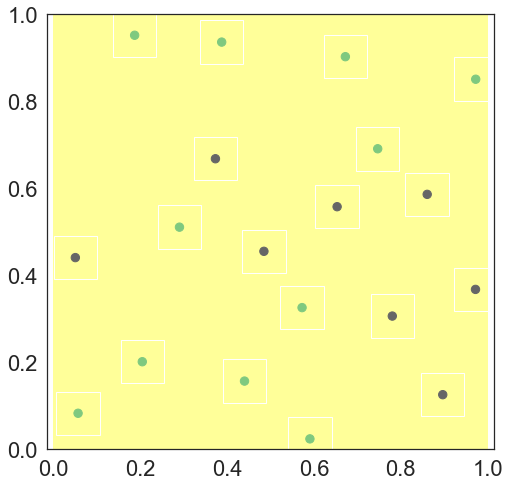

In [7]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = netSplit(X0)

ZZ = (np.argmax(np.stack([y0[:,a].detach().numpy() for a in range(0,y0.size()[1])]),axis=0))
ZZ.resize(100,100)

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="Accent")
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(), cmap="Accent", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))


## 5. Robust learning

In [9]:
from convex_adversarial import robust_loss

data = []
torch.manual_seed(123)
opt = optim.Adam(filter(lambda p: p.requires_grad,netSplit.parameters()), lr=1e-3)
for i in range(2000):
    robust_ce, robust_err = robust_loss(netSplit, epsilon, Variable(X), Variable(Y))
    out = netSplit(Variable(X))
    l2 = nn.CrossEntropyLoss()(out, Variable(Y))
    err = (out.max(1)[1].data != Y).float().mean()
    data.append([l2.data.item(), robust_ce.data.item(), err, robust_err])
    if i % 100 == 0:
        print(i,robust_ce.data.item(), robust_err)
    opt.zero_grad()
    (robust_ce).backward()
    opt.step()
print(l2.data.item(), robust_ce.data.item(), robust_err)

0 0.6902041435241699 0.42105263157894735
100 0.680886447429657 0.42105263157894735
200 0.6804508566856384 0.42105263157894735
300 0.6794897317886353 0.42105263157894735
400 0.672946035861969 0.42105263157894735
500 0.6381545662879944 0.3157894736842105
600 0.5868343710899353 0.2631578947368421
700 0.5617818832397461 0.3157894736842105
800 0.5601843595504761 0.3157894736842105
900 0.5600517392158508 0.3157894736842105
1000 0.5600310564041138 0.3157894736842105
1100 0.5600223541259766 0.3157894736842105
1200 0.5600178837776184 0.3157894736842105
1300 0.5600096583366394 0.3157894736842105
1400 0.5600099563598633 0.3157894736842105
1500 0.5600071549415588 0.3157894736842105
1600 0.5600104928016663 0.3157894736842105
1700 0.5600039958953857 0.3157894736842105
1800 0.5600013136863708 0.3157894736842105
1900 0.5600094795227051 0.3157894736842105
0.4335787296295166 0.5600011944770813 0.3157894736842105


## 6. Visualize Network -- Robust Version

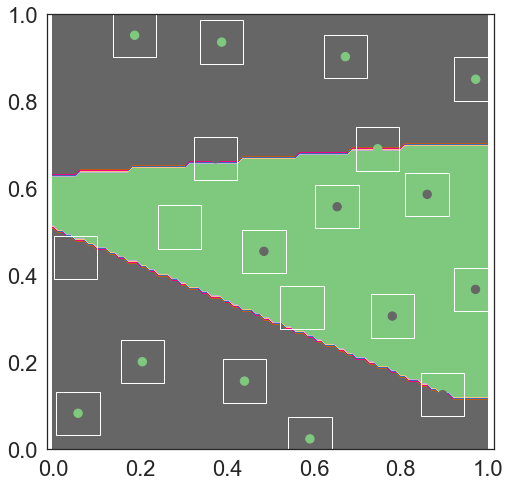

In [10]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = netSplit(X0)

ZZ = (np.argmax(np.stack([y0[:,a].detach().numpy() for a in range(0,y0.size()[1])]),axis=0))
ZZ.resize(100,100)

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="Accent")
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy(), cmap="Accent", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
